<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[21:03:59] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


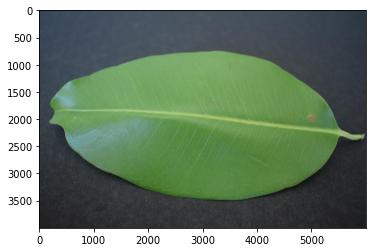

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

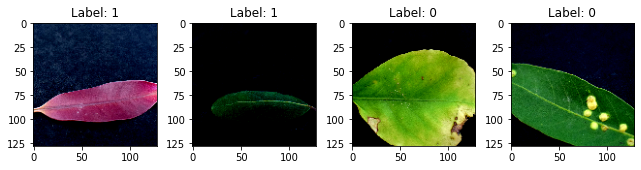

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[21:04:04] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[21:04:06] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2544239051821164 samples/sec                   batch loss = 1.114969253540039 | accuracy = 0.6


Epoch[1] Batch[10] Speed: 1.2120948706152164 samples/sec                   batch loss = 1.0539573431015015 | accuracy = 0.5


Epoch[1] Batch[15] Speed: 1.248627881530652 samples/sec                   batch loss = 1.8742620944976807 | accuracy = 0.4666666666666667


Epoch[1] Batch[20] Speed: 1.2720980111716018 samples/sec                   batch loss = 0.578082263469696 | accuracy = 0.5125


Epoch[1] Batch[25] Speed: 1.2682695324940652 samples/sec                   batch loss = 0.41285210847854614 | accuracy = 0.53


Epoch[1] Batch[30] Speed: 1.271430512560188 samples/sec                   batch loss = 0.534960925579071 | accuracy = 0.5333333333333333


Epoch[1] Batch[35] Speed: 1.2699022656378498 samples/sec                   batch loss = 0.8370819091796875 | accuracy = 0.5571428571428572


Epoch[1] Batch[40] Speed: 1.2666994241072818 samples/sec                   batch loss = 0.6754915714263916 | accuracy = 0.5625


Epoch[1] Batch[45] Speed: 1.2737479724269039 samples/sec                   batch loss = 0.5105863809585571 | accuracy = 0.5833333333333334


Epoch[1] Batch[50] Speed: 1.2725817200544374 samples/sec                   batch loss = 0.9271604418754578 | accuracy = 0.58


Epoch[1] Batch[55] Speed: 1.266442020846166 samples/sec                   batch loss = 0.9891828298568726 | accuracy = 0.5954545454545455


Epoch[1] Batch[60] Speed: 1.269904091949652 samples/sec                   batch loss = 0.8568357229232788 | accuracy = 0.5875


Epoch[1] Batch[65] Speed: 1.2701788675301582 samples/sec                   batch loss = 0.6788885593414307 | accuracy = 0.5923076923076923


Epoch[1] Batch[70] Speed: 1.274692993419578 samples/sec                   batch loss = 0.4274527430534363 | accuracy = 0.6


Epoch[1] Batch[75] Speed: 1.2734465188570812 samples/sec                   batch loss = 1.4767158031463623 | accuracy = 0.6066666666666667


Epoch[1] Batch[80] Speed: 1.2669376057309518 samples/sec                   batch loss = 1.0713750123977661 | accuracy = 0.60625


Epoch[1] Batch[85] Speed: 1.2699014005446192 samples/sec                   batch loss = 0.47778087854385376 | accuracy = 0.6058823529411764


Epoch[1] Batch[90] Speed: 1.260808056562712 samples/sec                   batch loss = 0.9239317178726196 | accuracy = 0.6083333333333333


Epoch[1] Batch[95] Speed: 1.2661223248444535 samples/sec                   batch loss = 0.6191685199737549 | accuracy = 0.6157894736842106


Epoch[1] Batch[100] Speed: 1.272372965126266 samples/sec                   batch loss = 0.5438439846038818 | accuracy = 0.61


Epoch[1] Batch[105] Speed: 1.2712992932812657 samples/sec                   batch loss = 0.6750848293304443 | accuracy = 0.6071428571428571


Epoch[1] Batch[110] Speed: 1.2682332929593283 samples/sec                   batch loss = 0.8953250646591187 | accuracy = 0.6090909090909091


Epoch[1] Batch[115] Speed: 1.270619256272054 samples/sec                   batch loss = 0.43144065141677856 | accuracy = 0.6130434782608696


Epoch[1] Batch[120] Speed: 1.2669864009712255 samples/sec                   batch loss = 1.0261727571487427 | accuracy = 0.6125


Epoch[1] Batch[125] Speed: 1.268275189116242 samples/sec                   batch loss = 0.7213784456253052 | accuracy = 0.616


Epoch[1] Batch[130] Speed: 1.2684876845547566 samples/sec                   batch loss = 0.4651634395122528 | accuracy = 0.6211538461538462


Epoch[1] Batch[135] Speed: 1.2762364888939872 samples/sec                   batch loss = 0.2624412178993225 | accuracy = 0.6203703703703703


Epoch[1] Batch[140] Speed: 1.2686069087940315 samples/sec                   batch loss = 0.5746411085128784 | accuracy = 0.6214285714285714


Epoch[1] Batch[145] Speed: 1.277030051646093 samples/sec                   batch loss = 0.5527105331420898 | accuracy = 0.6206896551724138


Epoch[1] Batch[150] Speed: 1.2639286694461138 samples/sec                   batch loss = 0.6691347360610962 | accuracy = 0.62


Epoch[1] Batch[155] Speed: 1.2696673880552907 samples/sec                   batch loss = 0.5350273847579956 | accuracy = 0.6258064516129033


Epoch[1] Batch[160] Speed: 1.2656857156565804 samples/sec                   batch loss = 0.664319634437561 | accuracy = 0.6234375


Epoch[1] Batch[165] Speed: 1.2670512757577703 samples/sec                   batch loss = 1.094246506690979 | accuracy = 0.6227272727272727


Epoch[1] Batch[170] Speed: 1.2712847471436053 samples/sec                   batch loss = 0.6384609341621399 | accuracy = 0.6220588235294118


Epoch[1] Batch[175] Speed: 1.2674334828845801 samples/sec                   batch loss = 0.5389832854270935 | accuracy = 0.6242857142857143


Epoch[1] Batch[180] Speed: 1.2660086303595932 samples/sec                   batch loss = 1.062685251235962 | accuracy = 0.6236111111111111


Epoch[1] Batch[185] Speed: 1.2676907146496448 samples/sec                   batch loss = 0.7503172755241394 | accuracy = 0.6243243243243243


Epoch[1] Batch[190] Speed: 1.2743576965177905 samples/sec                   batch loss = 0.7275663614273071 | accuracy = 0.6302631578947369


Epoch[1] Batch[195] Speed: 1.2742808441756954 samples/sec                   batch loss = 0.6852311491966248 | accuracy = 0.6294871794871795


Epoch[1] Batch[200] Speed: 1.2694772623712474 samples/sec                   batch loss = 0.5026522278785706 | accuracy = 0.63125


Epoch[1] Batch[205] Speed: 1.2684484595962746 samples/sec                   batch loss = 0.42503267526626587 | accuracy = 0.6353658536585366


Epoch[1] Batch[210] Speed: 1.2711797550959052 samples/sec                   batch loss = 0.43763166666030884 | accuracy = 0.6392857142857142


Epoch[1] Batch[215] Speed: 1.2674579948886828 samples/sec                   batch loss = 0.8644576072692871 | accuracy = 0.6395348837209303


Epoch[1] Batch[220] Speed: 1.2696600855626514 samples/sec                   batch loss = 0.7495233416557312 | accuracy = 0.6397727272727273


Epoch[1] Batch[225] Speed: 1.2670629500972281 samples/sec                   batch loss = 0.6275236010551453 | accuracy = 0.6411111111111111


Epoch[1] Batch[230] Speed: 1.2641611426416852 samples/sec                   batch loss = 0.32537397742271423 | accuracy = 0.6478260869565218


Epoch[1] Batch[235] Speed: 1.2685330504292291 samples/sec                   batch loss = 0.46346530318260193 | accuracy = 0.65


Epoch[1] Batch[240] Speed: 1.268390154116832 samples/sec                   batch loss = 0.5872002243995667 | accuracy = 0.6489583333333333


Epoch[1] Batch[245] Speed: 1.2673889615521579 samples/sec                   batch loss = 0.2263064682483673 | accuracy = 0.65


Epoch[1] Batch[250] Speed: 1.264252784002966 samples/sec                   batch loss = 0.7047268152236938 | accuracy = 0.651


Epoch[1] Batch[255] Speed: 1.2711328514096876 samples/sec                   batch loss = 0.7036891579627991 | accuracy = 0.6490196078431373


Epoch[1] Batch[260] Speed: 1.2688922555156243 samples/sec                   batch loss = 0.37632662057876587 | accuracy = 0.65


Epoch[1] Batch[265] Speed: 1.265134915698096 samples/sec                   batch loss = 0.3278842568397522 | accuracy = 0.6528301886792452


Epoch[1] Batch[270] Speed: 1.2672753266551395 samples/sec                   batch loss = 0.4660800099372864 | accuracy = 0.6546296296296297


Epoch[1] Batch[275] Speed: 1.267967024666051 samples/sec                   batch loss = 0.7397844791412354 | accuracy = 0.6536363636363637


Epoch[1] Batch[280] Speed: 1.2630975704525251 samples/sec                   batch loss = 0.6540302038192749 | accuracy = 0.6526785714285714


Epoch[1] Batch[285] Speed: 1.2750360249848214 samples/sec                   batch loss = 0.20536504685878754 | accuracy = 0.65


Epoch[1] Batch[290] Speed: 1.2684211282353697 samples/sec                   batch loss = 0.438104510307312 | accuracy = 0.653448275862069


Epoch[1] Batch[295] Speed: 1.2657943860927225 samples/sec                   batch loss = 0.7513435482978821 | accuracy = 0.6542372881355932


Epoch[1] Batch[300] Speed: 1.2702485898317368 samples/sec                   batch loss = 0.4254240095615387 | accuracy = 0.655


Epoch[1] Batch[305] Speed: 1.2676321914741442 samples/sec                   batch loss = 0.8614431023597717 | accuracy = 0.6524590163934426


Epoch[1] Batch[310] Speed: 1.266836678485642 samples/sec                   batch loss = 1.0607256889343262 | accuracy = 0.6516129032258065


Epoch[1] Batch[315] Speed: 1.2713926469482726 samples/sec                   batch loss = 0.35111215710639954 | accuracy = 0.653968253968254


Epoch[1] Batch[320] Speed: 1.261219689057006 samples/sec                   batch loss = 0.6926273703575134 | accuracy = 0.6546875


Epoch[1] Batch[325] Speed: 1.2634237325711972 samples/sec                   batch loss = 0.6562101244926453 | accuracy = 0.6553846153846153


Epoch[1] Batch[330] Speed: 1.260666800518898 samples/sec                   batch loss = 0.28028810024261475 | accuracy = 0.6568181818181819


Epoch[1] Batch[335] Speed: 1.265929820537121 samples/sec                   batch loss = 0.22332018613815308 | accuracy = 0.6567164179104478


Epoch[1] Batch[340] Speed: 1.2696717119392102 samples/sec                   batch loss = 0.7454071640968323 | accuracy = 0.6558823529411765


Epoch[1] Batch[345] Speed: 1.2683139239526433 samples/sec                   batch loss = 0.7410392761230469 | accuracy = 0.658695652173913


Epoch[1] Batch[350] Speed: 1.2647371224551611 samples/sec                   batch loss = 0.5045586824417114 | accuracy = 0.6592857142857143


Epoch[1] Batch[355] Speed: 1.2712698160240068 samples/sec                   batch loss = 0.15594002604484558 | accuracy = 0.6612676056338028


Epoch[1] Batch[360] Speed: 1.274658516412926 samples/sec                   batch loss = 0.2950374484062195 | accuracy = 0.6631944444444444


Epoch[1] Batch[365] Speed: 1.271083062166882 samples/sec                   batch loss = 0.6832927465438843 | accuracy = 0.6636986301369863


Epoch[1] Batch[370] Speed: 1.2689390899682644 samples/sec                   batch loss = 0.4177020192146301 | accuracy = 0.6662162162162162


Epoch[1] Batch[375] Speed: 1.2657256293427892 samples/sec                   batch loss = 0.6370365023612976 | accuracy = 0.6653333333333333


Epoch[1] Batch[380] Speed: 1.2690711663889955 samples/sec                   batch loss = 0.2726486027240753 | accuracy = 0.6677631578947368


Epoch[1] Batch[385] Speed: 1.278384268661907 samples/sec                   batch loss = 0.744511604309082 | accuracy = 0.6662337662337663


Epoch[1] Batch[390] Speed: 1.2664555003672802 samples/sec                   batch loss = 0.33392658829689026 | accuracy = 0.666025641025641


Epoch[1] Batch[395] Speed: 1.26760930090022 samples/sec                   batch loss = 0.1673213690519333 | accuracy = 0.6683544303797468


Epoch[1] Batch[400] Speed: 1.2705044641258065 samples/sec                   batch loss = 0.14299209415912628 | accuracy = 0.66875


Epoch[1] Batch[405] Speed: 1.2730367206838449 samples/sec                   batch loss = 0.5106465220451355 | accuracy = 0.6703703703703704


Epoch[1] Batch[410] Speed: 1.2684535424002943 samples/sec                   batch loss = 0.6109918355941772 | accuracy = 0.6707317073170732


Epoch[1] Batch[415] Speed: 1.273528684162045 samples/sec                   batch loss = 0.6544832587242126 | accuracy = 0.6734939759036145


Epoch[1] Batch[420] Speed: 1.2728373764638352 samples/sec                   batch loss = 0.3489149808883667 | accuracy = 0.6767857142857143


Epoch[1] Batch[425] Speed: 1.2722338332191696 samples/sec                   batch loss = 0.4569130539894104 | accuracy = 0.678235294117647


Epoch[1] Batch[430] Speed: 1.2679597417195405 samples/sec                   batch loss = 0.9928061962127686 | accuracy = 0.6779069767441861


Epoch[1] Batch[435] Speed: 1.266120318294188 samples/sec                   batch loss = 0.41829854249954224 | accuracy = 0.6787356321839081


Epoch[1] Batch[440] Speed: 1.2691949169916208 samples/sec                   batch loss = 0.5712735056877136 | accuracy = 0.6778409090909091


Epoch[1] Batch[445] Speed: 1.2675464757909447 samples/sec                   batch loss = 0.2671225666999817 | accuracy = 0.6792134831460674


Epoch[1] Batch[450] Speed: 1.269889001004499 samples/sec                   batch loss = 0.3262648284435272 | accuracy = 0.6805555555555556


Epoch[1] Batch[455] Speed: 1.2705807653952086 samples/sec                   batch loss = 1.5162339210510254 | accuracy = 0.6813186813186813


Epoch[1] Batch[460] Speed: 1.2694203030029496 samples/sec                   batch loss = 0.9349541068077087 | accuracy = 0.6809782608695653


Epoch[1] Batch[465] Speed: 1.2717162634930035 samples/sec                   batch loss = 0.38315269351005554 | accuracy = 0.682258064516129


Epoch[1] Batch[470] Speed: 1.2662134862641719 samples/sec                   batch loss = 0.4272144138813019 | accuracy = 0.6829787234042554


Epoch[1] Batch[475] Speed: 1.2684369515112819 samples/sec                   batch loss = 0.20530657470226288 | accuracy = 0.6831578947368421


Epoch[1] Batch[480] Speed: 1.2757305967235353 samples/sec                   batch loss = 0.19459789991378784 | accuracy = 0.6828125


Epoch[1] Batch[485] Speed: 1.2689862158269898 samples/sec                   batch loss = 0.67848801612854 | accuracy = 0.6814432989690722


Epoch[1] Batch[490] Speed: 1.2695365324354198 samples/sec                   batch loss = 0.5731826424598694 | accuracy = 0.6785714285714286


Epoch[1] Batch[495] Speed: 1.271181296138165 samples/sec                   batch loss = 0.49611058831214905 | accuracy = 0.6792929292929293


Epoch[1] Batch[500] Speed: 1.2669882189057402 samples/sec                   batch loss = 0.6152693629264832 | accuracy = 0.6795


Epoch[1] Batch[505] Speed: 1.2707088528192416 samples/sec                   batch loss = 0.26243114471435547 | accuracy = 0.6806930693069307


Epoch[1] Batch[510] Speed: 1.265920555057177 samples/sec                   batch loss = 0.3608703911304474 | accuracy = 0.6808823529411765


Epoch[1] Batch[515] Speed: 1.2750402886112333 samples/sec                   batch loss = 0.812786340713501 | accuracy = 0.6786407766990291


Epoch[1] Batch[520] Speed: 1.269153152065466 samples/sec                   batch loss = 0.5999671816825867 | accuracy = 0.6778846153846154


Epoch[1] Batch[525] Speed: 1.2657224781707743 samples/sec                   batch loss = 0.4010164141654968 | accuracy = 0.6785714285714286


Epoch[1] Batch[530] Speed: 1.2649927838960657 samples/sec                   batch loss = 0.3916831314563751 | accuracy = 0.6792452830188679


Epoch[1] Batch[535] Speed: 1.2650134816414427 samples/sec                   batch loss = 0.47473907470703125 | accuracy = 0.680373831775701


Epoch[1] Batch[540] Speed: 1.2678637296417614 samples/sec                   batch loss = 0.47337985038757324 | accuracy = 0.6800925925925926


Epoch[1] Batch[545] Speed: 1.2638609721110448 samples/sec                   batch loss = 0.7303996086120605 | accuracy = 0.6807339449541284


Epoch[1] Batch[550] Speed: 1.2649898271305873 samples/sec                   batch loss = 0.40803274512290955 | accuracy = 0.68


Epoch[1] Batch[555] Speed: 1.2667556613290003 samples/sec                   batch loss = 0.6226388216018677 | accuracy = 0.6810810810810811


Epoch[1] Batch[560] Speed: 1.260974459075829 samples/sec                   batch loss = 0.31561505794525146 | accuracy = 0.6816964285714285


Epoch[1] Batch[565] Speed: 1.2655218858469752 samples/sec                   batch loss = 0.7205548286437988 | accuracy = 0.6823008849557523


Epoch[1] Batch[570] Speed: 1.2633935728682248 samples/sec                   batch loss = 0.35484641790390015 | accuracy = 0.6824561403508772


Epoch[1] Batch[575] Speed: 1.2650988550765236 samples/sec                   batch loss = 0.4353763461112976 | accuracy = 0.6834782608695652


Epoch[1] Batch[580] Speed: 1.2714728129463777 samples/sec                   batch loss = 0.6389928460121155 | accuracy = 0.684051724137931


Epoch[1] Batch[585] Speed: 1.2737587067275338 samples/sec                   batch loss = 0.9943637847900391 | accuracy = 0.6833333333333333


Epoch[1] Batch[590] Speed: 1.270051656076226 samples/sec                   batch loss = 0.6938471794128418 | accuracy = 0.6838983050847458


Epoch[1] Batch[595] Speed: 1.2664563607719872 samples/sec                   batch loss = 0.655396580696106 | accuracy = 0.6840336134453782


Epoch[1] Batch[600] Speed: 1.2718600066848167 samples/sec                   batch loss = 0.2930697202682495 | accuracy = 0.685


Epoch[1] Batch[605] Speed: 1.2624929659646753 samples/sec                   batch loss = 0.8180404305458069 | accuracy = 0.6847107438016529


Epoch[1] Batch[610] Speed: 1.2660863990021765 samples/sec                   batch loss = 0.39446577429771423 | accuracy = 0.684016393442623


Epoch[1] Batch[615] Speed: 1.2745006820241882 samples/sec                   batch loss = 0.655191957950592 | accuracy = 0.6841463414634147


Epoch[1] Batch[620] Speed: 1.2670395059447834 samples/sec                   batch loss = 0.9388589262962341 | accuracy = 0.6850806451612903


Epoch[1] Batch[625] Speed: 1.268404538194271 samples/sec                   batch loss = 0.5425488948822021 | accuracy = 0.686


Epoch[1] Batch[630] Speed: 1.2663627747125321 samples/sec                   batch loss = 0.5618313550949097 | accuracy = 0.6857142857142857


Epoch[1] Batch[635] Speed: 1.2662618434563666 samples/sec                   batch loss = 0.3459308445453644 | accuracy = 0.687007874015748


Epoch[1] Batch[640] Speed: 1.2659339279582176 samples/sec                   batch loss = 0.344931423664093 | accuracy = 0.687890625


Epoch[1] Batch[645] Speed: 1.2643490122047258 samples/sec                   batch loss = 0.8190408945083618 | accuracy = 0.6883720930232559


Epoch[1] Batch[650] Speed: 1.2659937273863207 samples/sec                   batch loss = 0.39726218581199646 | accuracy = 0.6884615384615385


Epoch[1] Batch[655] Speed: 1.274577270394626 samples/sec                   batch loss = 0.6103867292404175 | accuracy = 0.6893129770992367


Epoch[1] Batch[660] Speed: 1.2765783119769003 samples/sec                   batch loss = 0.4343748390674591 | accuracy = 0.6890151515151515


Epoch[1] Batch[665] Speed: 1.2688137579780072 samples/sec                   batch loss = 0.7943652272224426 | accuracy = 0.687593984962406


Epoch[1] Batch[670] Speed: 1.2616635636223845 samples/sec                   batch loss = 0.9922114014625549 | accuracy = 0.6865671641791045


Epoch[1] Batch[675] Speed: 1.265872892515141 samples/sec                   batch loss = 0.5461441874504089 | accuracy = 0.687037037037037


Epoch[1] Batch[680] Speed: 1.2646089968569478 samples/sec                   batch loss = 0.3247731924057007 | accuracy = 0.6878676470588235


Epoch[1] Batch[685] Speed: 1.2652842361807355 samples/sec                   batch loss = 0.4877356290817261 | accuracy = 0.6883211678832116


Epoch[1] Batch[690] Speed: 1.2653494139321193 samples/sec                   batch loss = 0.43534955382347107 | accuracy = 0.6884057971014492


Epoch[1] Batch[695] Speed: 1.2660392971968801 samples/sec                   batch loss = 0.6428326368331909 | accuracy = 0.6870503597122302


Epoch[1] Batch[700] Speed: 1.2607718631987332 samples/sec                   batch loss = 0.5582243204116821 | accuracy = 0.6857142857142857


Epoch[1] Batch[705] Speed: 1.2617019905335591 samples/sec                   batch loss = 0.31466901302337646 | accuracy = 0.6861702127659575


Epoch[1] Batch[710] Speed: 1.2627121763038707 samples/sec                   batch loss = 0.48742184042930603 | accuracy = 0.6862676056338028


Epoch[1] Batch[715] Speed: 1.270487146072184 samples/sec                   batch loss = 0.33200129866600037 | accuracy = 0.6881118881118881


Epoch[1] Batch[720] Speed: 1.2610940761663354 samples/sec                   batch loss = 0.4824981689453125 | accuracy = 0.6885416666666667


Epoch[1] Batch[725] Speed: 1.2625032263890403 samples/sec                   batch loss = 0.4924777150154114 | accuracy = 0.6886206896551724


Epoch[1] Batch[730] Speed: 1.2658251380566858 samples/sec                   batch loss = 1.000100016593933 | accuracy = 0.689041095890411


Epoch[1] Batch[735] Speed: 1.2662515218483879 samples/sec                   batch loss = 0.20794902741909027 | accuracy = 0.6894557823129251


Epoch[1] Batch[740] Speed: 1.2687439052564433 samples/sec                   batch loss = 0.5111225247383118 | accuracy = 0.6902027027027027


Epoch[1] Batch[745] Speed: 1.2681607242444688 samples/sec                   batch loss = 0.49646520614624023 | accuracy = 0.6895973154362416


Epoch[1] Batch[750] Speed: 1.2654016182330132 samples/sec                   batch loss = 2.2586874961853027 | accuracy = 0.6893333333333334


Epoch[1] Batch[755] Speed: 1.2667747907738123 samples/sec                   batch loss = 1.09144926071167 | accuracy = 0.6887417218543046


Epoch[1] Batch[760] Speed: 1.2620322738200918 samples/sec                   batch loss = 0.4033290445804596 | accuracy = 0.6881578947368421


Epoch[1] Batch[765] Speed: 1.264852114402618 samples/sec                   batch loss = 0.5960131883621216 | accuracy = 0.6879084967320261


Epoch[1] Batch[770] Speed: 1.267974307696226 samples/sec                   batch loss = 0.7485990524291992 | accuracy = 0.6886363636363636


Epoch[1] Batch[775] Speed: 1.2633811098152237 samples/sec                   batch loss = 0.2854689657688141 | accuracy = 0.6896774193548387


Epoch[1] Batch[780] Speed: 1.2696239586769473 samples/sec                   batch loss = 0.5043410658836365 | accuracy = 0.6900641025641026


Epoch[1] Batch[785] Speed: 1.271521379958468 samples/sec                   batch loss = 0.3586212992668152 | accuracy = 0.6910828025477707


[Epoch 1] training: accuracy=0.6916243654822335
[Epoch 1] time cost: 649.2346630096436
[Epoch 1] validation: validation accuracy=0.7522222222222222


Epoch[2] Batch[5] Speed: 1.2755620227870819 samples/sec                   batch loss = 0.4903549253940582 | accuracy = 0.65


Epoch[2] Batch[10] Speed: 1.270501000477312 samples/sec                   batch loss = 1.0405337810516357 | accuracy = 0.675


Epoch[2] Batch[15] Speed: 1.266993481377165 samples/sec                   batch loss = 1.0220025777816772 | accuracy = 0.6833333333333333


Epoch[2] Batch[20] Speed: 1.2719907631171552 samples/sec                   batch loss = 0.8878623247146606 | accuracy = 0.7


Epoch[2] Batch[25] Speed: 1.2679893531682396 samples/sec                   batch loss = 0.48128849267959595 | accuracy = 0.72


Epoch[2] Batch[30] Speed: 1.2739535028524436 samples/sec                   batch loss = 0.5802872180938721 | accuracy = 0.7083333333333334


Epoch[2] Batch[35] Speed: 1.2797335515699588 samples/sec                   batch loss = 0.3580063283443451 | accuracy = 0.7142857142857143


Epoch[2] Batch[40] Speed: 1.2720322327923217 samples/sec                   batch loss = 0.7035834193229675 | accuracy = 0.71875


Epoch[2] Batch[45] Speed: 1.2769797021677474 samples/sec                   batch loss = 0.7740485668182373 | accuracy = 0.7111111111111111


Epoch[2] Batch[50] Speed: 1.2694722674161074 samples/sec                   batch loss = 0.4928131699562073 | accuracy = 0.715


Epoch[2] Batch[55] Speed: 1.2728140078293326 samples/sec                   batch loss = 0.7282067537307739 | accuracy = 0.7181818181818181


Epoch[2] Batch[60] Speed: 1.2716631513267247 samples/sec                   batch loss = 0.7660552263259888 | accuracy = 0.7125


Epoch[2] Batch[65] Speed: 1.2734630477312125 samples/sec                   batch loss = 0.2598641812801361 | accuracy = 0.7230769230769231


Epoch[2] Batch[70] Speed: 1.2703465024805776 samples/sec                   batch loss = 0.3325212895870209 | accuracy = 0.7321428571428571


Epoch[2] Batch[75] Speed: 1.273456088152965 samples/sec                   batch loss = 0.3399030864238739 | accuracy = 0.7466666666666667


Epoch[2] Batch[80] Speed: 1.2732803840085876 samples/sec                   batch loss = 0.6759951710700989 | accuracy = 0.74375


Epoch[2] Batch[85] Speed: 1.2715195489919033 samples/sec                   batch loss = 1.9914560317993164 | accuracy = 0.7352941176470589


Epoch[2] Batch[90] Speed: 1.270017429680418 samples/sec                   batch loss = 0.4123696982860565 | accuracy = 0.7305555555555555


Epoch[2] Batch[95] Speed: 1.2774925193751552 samples/sec                   batch loss = 0.5529146790504456 | accuracy = 0.7394736842105263


Epoch[2] Batch[100] Speed: 1.2670412283427817 samples/sec                   batch loss = 0.38084402680397034 | accuracy = 0.745


Epoch[2] Batch[105] Speed: 1.265112210622598 samples/sec                   batch loss = 0.42522963881492615 | accuracy = 0.7357142857142858


Epoch[2] Batch[110] Speed: 1.2673540168909367 samples/sec                   batch loss = 0.339863657951355 | accuracy = 0.7386363636363636


Epoch[2] Batch[115] Speed: 1.272431347839132 samples/sec                   batch loss = 0.40206772089004517 | accuracy = 0.741304347826087


Epoch[2] Batch[120] Speed: 1.272677868798364 samples/sec                   batch loss = 0.1692424714565277 | accuracy = 0.7375


Epoch[2] Batch[125] Speed: 1.2775176165637008 samples/sec                   batch loss = 0.4827144742012024 | accuracy = 0.738


Epoch[2] Batch[130] Speed: 1.2720523899598244 samples/sec                   batch loss = 0.33508405089378357 | accuracy = 0.7423076923076923


Epoch[2] Batch[135] Speed: 1.2727985579636698 samples/sec                   batch loss = 0.20352864265441895 | accuracy = 0.7462962962962963


Epoch[2] Batch[140] Speed: 1.2672641270145328 samples/sec                   batch loss = 0.31845057010650635 | accuracy = 0.7464285714285714


Epoch[2] Batch[145] Speed: 1.2729237126617898 samples/sec                   batch loss = 0.22909285128116608 | accuracy = 0.7482758620689656


Epoch[2] Batch[150] Speed: 1.2725155055728439 samples/sec                   batch loss = 0.36761704087257385 | accuracy = 0.7483333333333333


Epoch[2] Batch[155] Speed: 1.2775521511288872 samples/sec                   batch loss = 0.5150355100631714 | accuracy = 0.7451612903225806


Epoch[2] Batch[160] Speed: 1.273541541574975 samples/sec                   batch loss = 0.7814895510673523 | accuracy = 0.7484375


Epoch[2] Batch[165] Speed: 1.2732455002313547 samples/sec                   batch loss = 0.6305902004241943 | accuracy = 0.746969696969697


Epoch[2] Batch[170] Speed: 1.2725013176518167 samples/sec                   batch loss = 0.8648561835289001 | accuracy = 0.7485294117647059


Epoch[2] Batch[175] Speed: 1.2764745803977662 samples/sec                   batch loss = 0.6292486190795898 | accuracy = 0.7442857142857143


Epoch[2] Batch[180] Speed: 1.2710644764667454 samples/sec                   batch loss = 0.29851964116096497 | accuracy = 0.7486111111111111


Epoch[2] Batch[185] Speed: 1.2692484953353809 samples/sec                   batch loss = 0.33744603395462036 | accuracy = 0.7513513513513513


Epoch[2] Batch[190] Speed: 1.2698508426987127 samples/sec                   batch loss = 0.723202109336853 | accuracy = 0.7526315789473684


Epoch[2] Batch[195] Speed: 1.267827034255449 samples/sec                   batch loss = 0.34647518396377563 | accuracy = 0.75


Epoch[2] Batch[200] Speed: 1.2713497738508763 samples/sec                   batch loss = 0.28839242458343506 | accuracy = 0.75125


Epoch[2] Batch[205] Speed: 1.2716436811901406 samples/sec                   batch loss = 0.2309868484735489 | accuracy = 0.75


Epoch[2] Batch[210] Speed: 1.2744161647092371 samples/sec                   batch loss = 0.4813540279865265 | accuracy = 0.7464285714285714


Epoch[2] Batch[215] Speed: 1.2698702579732777 samples/sec                   batch loss = 0.3116667866706848 | accuracy = 0.75


Epoch[2] Batch[220] Speed: 1.274654739550826 samples/sec                   batch loss = 0.5589979290962219 | accuracy = 0.75


Epoch[2] Batch[225] Speed: 1.2739449901583189 samples/sec                   batch loss = 0.2601519525051117 | accuracy = 0.7533333333333333


Epoch[2] Batch[230] Speed: 1.2770907095720587 samples/sec                   batch loss = 0.4560151696205139 | accuracy = 0.7554347826086957


Epoch[2] Batch[235] Speed: 1.2711550026166045 samples/sec                   batch loss = 0.5313002467155457 | accuracy = 0.7553191489361702


Epoch[2] Batch[240] Speed: 1.2717190589930725 samples/sec                   batch loss = 0.3545305132865906 | accuracy = 0.759375


Epoch[2] Batch[245] Speed: 1.2737245703446087 samples/sec                   batch loss = 0.22671270370483398 | accuracy = 0.7581632653061224


Epoch[2] Batch[250] Speed: 1.2776993574116309 samples/sec                   batch loss = 0.39183568954467773 | accuracy = 0.757


Epoch[2] Batch[255] Speed: 1.2691714898899542 samples/sec                   batch loss = 0.9008702039718628 | accuracy = 0.7549019607843137


Epoch[2] Batch[260] Speed: 1.274129005780554 samples/sec                   batch loss = 0.5300096869468689 | accuracy = 0.7528846153846154


Epoch[2] Batch[265] Speed: 1.2734027339134881 samples/sec                   batch loss = 0.1403672993183136 | accuracy = 0.7528301886792453


Epoch[2] Batch[270] Speed: 1.270189541758732 samples/sec                   batch loss = 0.9901623129844666 | accuracy = 0.75


Epoch[2] Batch[275] Speed: 1.2706757458563076 samples/sec                   batch loss = 0.2997036576271057 | accuracy = 0.7527272727272727


Epoch[2] Batch[280] Speed: 1.2725961028279609 samples/sec                   batch loss = 0.40749242901802063 | accuracy = 0.7535714285714286


Epoch[2] Batch[285] Speed: 1.2698725647780322 samples/sec                   batch loss = 0.28224143385887146 | accuracy = 0.7552631578947369


Epoch[2] Batch[290] Speed: 1.2719247065445092 samples/sec                   batch loss = 0.3208089768886566 | accuracy = 0.7543103448275862


Epoch[2] Batch[295] Speed: 1.2709146551306847 samples/sec                   batch loss = 0.7077259421348572 | accuracy = 0.752542372881356


Epoch[2] Batch[300] Speed: 1.265949784764143 samples/sec                   batch loss = 0.41514742374420166 | accuracy = 0.7508333333333334


Epoch[2] Batch[305] Speed: 1.269202982259529 samples/sec                   batch loss = 0.4430767297744751 | accuracy = 0.7524590163934426


Epoch[2] Batch[310] Speed: 1.2730839581876563 samples/sec                   batch loss = 0.42171382904052734 | accuracy = 0.7540322580645161


Epoch[2] Batch[315] Speed: 1.2698460370293447 samples/sec                   batch loss = 0.2557468116283417 | accuracy = 0.7531746031746032


Epoch[2] Batch[320] Speed: 1.267057878431527 samples/sec                   batch loss = 0.6777265071868896 | accuracy = 0.753125


Epoch[2] Batch[325] Speed: 1.2681528639310735 samples/sec                   batch loss = 0.6537774801254272 | accuracy = 0.7530769230769231


Epoch[2] Batch[330] Speed: 1.274429233664431 samples/sec                   batch loss = 0.3362567126750946 | accuracy = 0.7507575757575757


Epoch[2] Batch[335] Speed: 1.2739110372487945 samples/sec                   batch loss = 0.5330533981323242 | accuracy = 0.7507462686567165


Epoch[2] Batch[340] Speed: 1.277179859961928 samples/sec                   batch loss = 0.27426451444625854 | accuracy = 0.7514705882352941


Epoch[2] Batch[345] Speed: 1.271600309266919 samples/sec                   batch loss = 0.5086515545845032 | accuracy = 0.7528985507246376


Epoch[2] Batch[350] Speed: 1.2710422321205215 samples/sec                   batch loss = 0.7451784610748291 | accuracy = 0.7521428571428571


Epoch[2] Batch[355] Speed: 1.2661504172159825 samples/sec                   batch loss = 0.6549562215805054 | accuracy = 0.7514084507042254


Epoch[2] Batch[360] Speed: 1.2728127525137483 samples/sec                   batch loss = 0.3529086112976074 | accuracy = 0.7506944444444444


Epoch[2] Batch[365] Speed: 1.2733112108762767 samples/sec                   batch loss = 0.771164059638977 | accuracy = 0.7506849315068493


Epoch[2] Batch[370] Speed: 1.2753683826435978 samples/sec                   batch loss = 0.5530486702919006 | accuracy = 0.7533783783783784


Epoch[2] Batch[375] Speed: 1.2702883109236878 samples/sec                   batch loss = 0.39708825945854187 | accuracy = 0.754


Epoch[2] Batch[380] Speed: 1.2739415077253302 samples/sec                   batch loss = 0.6916869282722473 | accuracy = 0.7519736842105263


Epoch[2] Batch[385] Speed: 1.2714655860295643 samples/sec                   batch loss = 0.6662607192993164 | accuracy = 0.7506493506493507


Epoch[2] Batch[390] Speed: 1.2747550761032735 samples/sec                   batch loss = 0.47564077377319336 | accuracy = 0.75


Epoch[2] Batch[395] Speed: 1.2645618142825281 samples/sec                   batch loss = 0.41079071164131165 | accuracy = 0.7518987341772152


Epoch[2] Batch[400] Speed: 1.2719196923111447 samples/sec                   batch loss = 0.33067941665649414 | accuracy = 0.7525


Epoch[2] Batch[405] Speed: 1.2710616838437465 samples/sec                   batch loss = 0.4512445032596588 | accuracy = 0.7530864197530864


Epoch[2] Batch[410] Speed: 1.2662301146052937 samples/sec                   batch loss = 0.4333573579788208 | accuracy = 0.7536585365853659


Epoch[2] Batch[415] Speed: 1.2719131352963973 samples/sec                   batch loss = 0.5407552123069763 | accuracy = 0.7542168674698795


Epoch[2] Batch[420] Speed: 1.2692916109431094 samples/sec                   batch loss = 0.4920724630355835 | accuracy = 0.7529761904761905


Epoch[2] Batch[425] Speed: 1.2692084551782727 samples/sec                   batch loss = 0.657270610332489 | accuracy = 0.7529411764705882


Epoch[2] Batch[430] Speed: 1.2734606312023669 samples/sec                   batch loss = 0.5780324339866638 | accuracy = 0.7511627906976744


Epoch[2] Batch[435] Speed: 1.2759326919756981 samples/sec                   batch loss = 0.2993132472038269 | accuracy = 0.7511494252873563


Epoch[2] Batch[440] Speed: 1.2767913642313828 samples/sec                   batch loss = 0.4401662051677704 | accuracy = 0.7522727272727273


Epoch[2] Batch[445] Speed: 1.2701367493518048 samples/sec                   batch loss = 0.47313007712364197 | accuracy = 0.751123595505618


Epoch[2] Batch[450] Speed: 1.2693184996647249 samples/sec                   batch loss = 0.38798069953918457 | accuracy = 0.7516666666666667


Epoch[2] Batch[455] Speed: 1.271287733409613 samples/sec                   batch loss = 0.5970048308372498 | accuracy = 0.7505494505494505


Epoch[2] Batch[460] Speed: 1.2684308139513345 samples/sec                   batch loss = 0.5384294986724854 | accuracy = 0.7489130434782608


Epoch[2] Batch[465] Speed: 1.2704756971737448 samples/sec                   batch loss = 0.29727864265441895 | accuracy = 0.7483870967741936


Epoch[2] Batch[470] Speed: 1.269684683767672 samples/sec                   batch loss = 0.8040246963500977 | accuracy = 0.7468085106382979


Epoch[2] Batch[475] Speed: 1.2689483037101719 samples/sec                   batch loss = 0.47625282406806946 | accuracy = 0.7468421052631579


Epoch[2] Batch[480] Speed: 1.2717880828236683 samples/sec                   batch loss = 0.4931623041629791 | accuracy = 0.7463541666666667


Epoch[2] Batch[485] Speed: 1.2709349694500771 samples/sec                   batch loss = 0.09440330415964127 | accuracy = 0.7463917525773196


Epoch[2] Batch[490] Speed: 1.2724781543790333 samples/sec                   batch loss = 0.3774660527706146 | accuracy = 0.7464285714285714


Epoch[2] Batch[495] Speed: 1.2721065956554674 samples/sec                   batch loss = 0.4092763066291809 | accuracy = 0.7459595959595959


Epoch[2] Batch[500] Speed: 1.2764800190879886 samples/sec                   batch loss = 0.572873055934906 | accuracy = 0.747


Epoch[2] Batch[505] Speed: 1.2789004570579081 samples/sec                   batch loss = 0.2238989919424057 | accuracy = 0.7475247524752475


Epoch[2] Batch[510] Speed: 1.2759225032125805 samples/sec                   batch loss = 0.7484431862831116 | accuracy = 0.7470588235294118


Epoch[2] Batch[515] Speed: 1.2739342527177535 samples/sec                   batch loss = 0.67507404088974 | accuracy = 0.7466019417475728


Epoch[2] Batch[520] Speed: 1.275113549919213 samples/sec                   batch loss = 1.0701624155044556 | accuracy = 0.7466346153846154


Epoch[2] Batch[525] Speed: 1.2813319509759558 samples/sec                   batch loss = 0.2861136496067047 | accuracy = 0.7485714285714286


Epoch[2] Batch[530] Speed: 1.2724411914028164 samples/sec                   batch loss = 0.4191391170024872 | accuracy = 0.7490566037735849


Epoch[2] Batch[535] Speed: 1.2649278336182532 samples/sec                   batch loss = 0.2836796045303345 | accuracy = 0.7485981308411215


Epoch[2] Batch[540] Speed: 1.2759465683624234 samples/sec                   batch loss = 0.20601755380630493 | accuracy = 0.7486111111111111


Epoch[2] Batch[545] Speed: 1.2752342168519382 samples/sec                   batch loss = 0.3692820072174072 | accuracy = 0.7472477064220183


Epoch[2] Batch[550] Speed: 1.2703312086458642 samples/sec                   batch loss = 0.956947386264801 | accuracy = 0.7463636363636363


Epoch[2] Batch[555] Speed: 1.271260472211454 samples/sec                   batch loss = 0.29429441690444946 | accuracy = 0.7472972972972973


Epoch[2] Batch[560] Speed: 1.272787067369299 samples/sec                   batch loss = 0.5404656529426575 | accuracy = 0.746875


Epoch[2] Batch[565] Speed: 1.2759569515904652 samples/sec                   batch loss = 0.4520297944545746 | accuracy = 0.7469026548672566


Epoch[2] Batch[570] Speed: 1.2702487821797073 samples/sec                   batch loss = 0.4374581575393677 | accuracy = 0.7469298245614036


Epoch[2] Batch[575] Speed: 1.2730226177323993 samples/sec                   batch loss = 0.619296669960022 | accuracy = 0.7465217391304347


Epoch[2] Batch[580] Speed: 1.2783788137327678 samples/sec                   batch loss = 0.5534099340438843 | accuracy = 0.7474137931034482


Epoch[2] Batch[585] Speed: 1.2688076167710354 samples/sec                   batch loss = 0.2873043119907379 | accuracy = 0.7482905982905983


Epoch[2] Batch[590] Speed: 1.2735217238663643 samples/sec                   batch loss = 0.4232933223247528 | accuracy = 0.7487288135593221


Epoch[2] Batch[595] Speed: 1.2724083801161314 samples/sec                   batch loss = 0.35071125626564026 | accuracy = 0.7495798319327731


Epoch[2] Batch[600] Speed: 1.2703731473364002 samples/sec                   batch loss = 0.44282886385917664 | accuracy = 0.75


Epoch[2] Batch[605] Speed: 1.2719188244670758 samples/sec                   batch loss = 0.3155409097671509 | accuracy = 0.7487603305785124


Epoch[2] Batch[610] Speed: 1.274089914945322 samples/sec                   batch loss = 0.45967644453048706 | accuracy = 0.7487704918032787


Epoch[2] Batch[615] Speed: 1.2725686889631707 samples/sec                   batch loss = 0.3598654568195343 | accuracy = 0.748780487804878


Epoch[2] Batch[620] Speed: 1.2746745925378895 samples/sec                   batch loss = 0.6657253503799438 | accuracy = 0.7483870967741936


Epoch[2] Batch[625] Speed: 1.272627572311919 samples/sec                   batch loss = 0.620132327079773 | accuracy = 0.748


Epoch[2] Batch[630] Speed: 1.27903451785891 samples/sec                   batch loss = 0.32361072301864624 | accuracy = 0.7488095238095238


Epoch[2] Batch[635] Speed: 1.2682281160519993 samples/sec                   batch loss = 0.2636778950691223 | accuracy = 0.7492125984251968


Epoch[2] Batch[640] Speed: 1.2718910540821553 samples/sec                   batch loss = 0.3929917514324188 | accuracy = 0.74921875


Epoch[2] Batch[645] Speed: 1.2708697926312924 samples/sec                   batch loss = 1.4281153678894043 | accuracy = 0.7492248062015504


Epoch[2] Batch[650] Speed: 1.2667006673932404 samples/sec                   batch loss = 0.21806477010250092 | accuracy = 0.7496153846153846


Epoch[2] Batch[655] Speed: 1.2727809841974482 samples/sec                   batch loss = 0.5155783891677856 | accuracy = 0.75


Epoch[2] Batch[660] Speed: 1.268159094659295 samples/sec                   batch loss = 0.29362767934799194 | accuracy = 0.7503787878787879


Epoch[2] Batch[665] Speed: 1.273309278113441 samples/sec                   batch loss = 0.33007651567459106 | accuracy = 0.7511278195488722


Epoch[2] Batch[670] Speed: 1.2759618036241198 samples/sec                   batch loss = 0.4410293996334076 | accuracy = 0.7514925373134328


Epoch[2] Batch[675] Speed: 1.2740578893407222 samples/sec                   batch loss = 0.3646202087402344 | accuracy = 0.7522222222222222


Epoch[2] Batch[680] Speed: 1.2757748329373948 samples/sec                   batch loss = 0.6019648909568787 | accuracy = 0.7518382352941176


Epoch[2] Batch[685] Speed: 1.274710426323871 samples/sec                   batch loss = 0.7834187746047974 | accuracy = 0.7518248175182481


Epoch[2] Batch[690] Speed: 1.2713933213796467 samples/sec                   batch loss = 0.23531638085842133 | accuracy = 0.7525362318840579


Epoch[2] Batch[695] Speed: 1.2729376202586966 samples/sec                   batch loss = 0.4960084557533264 | accuracy = 0.7525179856115108


Epoch[2] Batch[700] Speed: 1.2678932407884702 samples/sec                   batch loss = 0.5800289511680603 | accuracy = 0.7514285714285714


Epoch[2] Batch[705] Speed: 1.2719381101700897 samples/sec                   batch loss = 0.2902551293373108 | accuracy = 0.7528368794326241


Epoch[2] Batch[710] Speed: 1.275274831984305 samples/sec                   batch loss = 0.5959660410881042 | accuracy = 0.7517605633802817


Epoch[2] Batch[715] Speed: 1.270329862036548 samples/sec                   batch loss = 0.2667289078235626 | accuracy = 0.7517482517482518


Epoch[2] Batch[720] Speed: 1.2718741803086058 samples/sec                   batch loss = 0.5299525856971741 | accuracy = 0.7517361111111112


Epoch[2] Batch[725] Speed: 1.27507420483689 samples/sec                   batch loss = 0.4590916633605957 | accuracy = 0.7517241379310344


Epoch[2] Batch[730] Speed: 1.277161289988614 samples/sec                   batch loss = 0.08222270011901855 | accuracy = 0.7520547945205479


Epoch[2] Batch[735] Speed: 1.2748125152349419 samples/sec                   batch loss = 1.3775486946105957 | accuracy = 0.7517006802721088


Epoch[2] Batch[740] Speed: 1.2681782665147725 samples/sec                   batch loss = 0.46725910902023315 | accuracy = 0.7520270270270271


Epoch[2] Batch[745] Speed: 1.2705529571877558 samples/sec                   batch loss = 0.35487252473831177 | accuracy = 0.7520134228187919


Epoch[2] Batch[750] Speed: 1.2688099197166833 samples/sec                   batch loss = 0.16486844420433044 | accuracy = 0.7523333333333333


Epoch[2] Batch[755] Speed: 1.2712243505166778 samples/sec                   batch loss = 0.5526324510574341 | accuracy = 0.752317880794702


Epoch[2] Batch[760] Speed: 1.273055074307762 samples/sec                   batch loss = 0.3208366334438324 | accuracy = 0.7519736842105263


Epoch[2] Batch[765] Speed: 1.2753970807261148 samples/sec                   batch loss = 0.2801435887813568 | accuracy = 0.7529411764705882


Epoch[2] Batch[770] Speed: 1.278823153314569 samples/sec                   batch loss = 0.5051159858703613 | accuracy = 0.7529220779220779


Epoch[2] Batch[775] Speed: 1.27441887528532 samples/sec                   batch loss = 0.7114856243133545 | accuracy = 0.7541935483870967


Epoch[2] Batch[780] Speed: 1.2742661329456328 samples/sec                   batch loss = 1.1090154647827148 | accuracy = 0.7551282051282051


Epoch[2] Batch[785] Speed: 1.2712320563059822 samples/sec                   batch loss = 0.5357486605644226 | accuracy = 0.7547770700636943


[Epoch 2] training: accuracy=0.7550761421319797
[Epoch 2] time cost: 637.1779327392578
[Epoch 2] validation: validation accuracy=0.8122222222222222


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7933333333333333

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)